## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import pandas as pd
import numpy as np


class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Тип регуляризации

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Метод расчёта весов

    Attributes
    ----------
    coefs_ : ndarray (p, 1)
        Вектор коэффициентов
    intercept_ : float
        Свободный член
    """

    def __init__(self, regularization=None, weight_calc='matrix',
                 lambda_1=None, lambda_2=None, batch_size=20,
                 lr=0.01, n_iter=1000):

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.lr = lr
        self.n_iter = n_iter

        self.coefs_ = None
        self.intercept_ = None

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1, 1)

        n, p = X.shape
        X_bias = np.hstack([np.ones((n, 1)), X])

        if self.weight_calc == 'matrix':
            if self.regularization == 'l2':
                I = np.eye(p + 1)
                I[0, 0] = 0
                W = np.linalg.inv(
                    X_bias.T @ X_bias + self.lambda_2 * I
                ) @ X_bias.T @ y
            else:
                W = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y

        else:
            W = np.zeros((p + 1, 1))

            for _ in range(self.n_iter):

                if self.weight_calc == 'sgd':
                    idx = np.random.choice(n, self.batch_size, replace=False)
                    X_batch = X_bias[idx]
                    y_batch = y[idx]
                else:
                    X_batch = X_bias
                    y_batch = y

                y_pred = X_batch @ W
                grad = 2 / len(y_batch) * X_batch.T @ (y_pred - y_batch)

                if self.regularization in ['l1', 'l1l2']:
                    grad[1:] += self.lambda_1 * np.sign(W[1:])
                if self.regularization in ['l2', 'l1l2']:
                    grad[1:] += 2 * self.lambda_2 * W[1:]

                W -= self.lr * grad

        self.intercept_ = W[0, 0]
        self.coefs_ = W[1:]

        return self

    def predict(self, X: np.array, ss=True):
        X = np.asarray(X)
        y_pred = X @ self.coefs_ + self.intercept_
        return y_pred.flatten()

    def score(self, X: np.array, y: np.array):
        y = np.asarray(y)
        y_pred = self.predict(X)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)

        return 1 - ss_res / ss_tot


Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [7]:
df = pd.read_csv("Used_fiat_500_in_Italy_dataset.csv")

In [8]:
df.shape

(380, 9)

In [9]:
df.head()

,model,engine_power,transmission,age_in_days,km,previous_owners,lat,lon,price
0,pop,69,manual,4474,56779,2,45.071079,7.46403,4490
1,lounge,69,manual,2708,160000,1,45.069679,7.70492,4500
2,lounge,69,automatic,3470,170000,2,45.514599,9.28434,4500
3,sport,69,manual,3288,132000,2,41.903221,12.49565,4700
4,sport,69,manual,3712,124490,2,45.532661,9.03892,4790


In [11]:
df.describe()

,engine_power,age_in_days,km,previous_owners,lat,lon,price
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,73.015789,3310.265789,102196.250000,1.510526,44.257712,10.742644,5881.655263
std,9.984672,1437.555063,47115.355234,0.560244,1.767518,2.167753,2170.617946
min,69.000000,91.000000,4981.000000,1.000000,37.510872,7.320720,2890.000000
25%,69.000000,3097.250000,76611.750000,1.000000,43.514196,9.159140,4600.000000
50%,69.000000,3927.000000,112000.000000,1.000000,45.069679,10.301505,5000.000000
75%,69.000000,4322.000000,135000.000000,2.000000,45.556942,12.346788,5500.000000
max,101.000000,4719.000000,259000.000000,4.000000,46.781651,18.168011,15900.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            380 non-null    object 
 1   engine_power     380 non-null    int64  
 2   transmission     380 non-null    object 
 3   age_in_days      380 non-null    int64  
 4   km               380 non-null    int64  
 5   previous_owners  380 non-null    int64  
 6   lat              380 non-null    float64
 7   lon              380 non-null    float64
 8   price            380 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 26.8+ KB


In [13]:
y = df["price"].values
X = pd.get_dummies(df.drop(columns=["price"]), drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_names = X.columns


In [4]:
results = []
trained_models = {}

models = [
    ("MyLR_matrix", MyLinearRegression()),
    ("MyLR_L2_gd", MyLinearRegression(regularization="l2", weight_calc="gd", lambda_2=0.1)),
    ("MyLR_L1_sgd", MyLinearRegression(regularization="l1", weight_calc="sgd", lambda_1=0.01)),
    ("sklearn_LR", LinearRegression()),
    ("sklearn_Ridge", Ridge(alpha=0.1)),
    ("sklearn_Lasso", Lasso(alpha=0.01, max_iter=5000))
]

for name, model in models:
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start

    r2 = r2_score(y_test, y_pred)

    results.append([name, r2, fit_time, pred_time])
    trained_models[name] = model

results_df = pd.DataFrame(
    results,
    columns=["Model", "R2", "Fit time (s)", "Predict time (s)"]
)

print(results_df)


           Model        R2  Fit time (s)  Predict time (s)
0    MyLR_matrix  0.894534      0.007623          0.000029
1     MyLR_L2_gd  0.886592      0.014799          0.000021
2    MyLR_L1_sgd  0.892873      0.042952          0.000015
3     sklearn_LR  0.894534      0.022249          0.000290
4  sklearn_Ridge  0.894520      0.003910          0.000283
5  sklearn_Lasso  0.894532      0.001425          0.000217


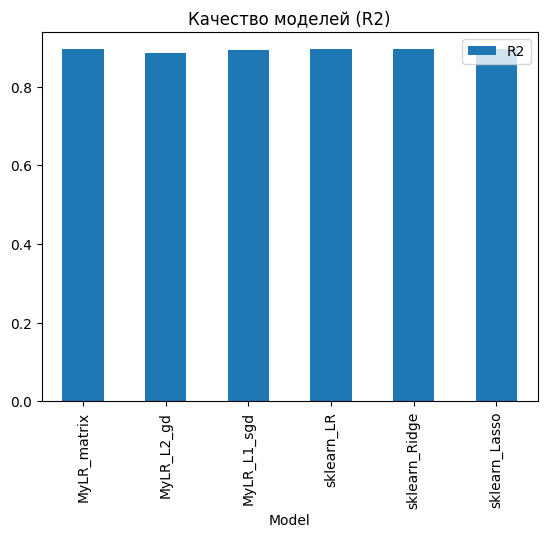

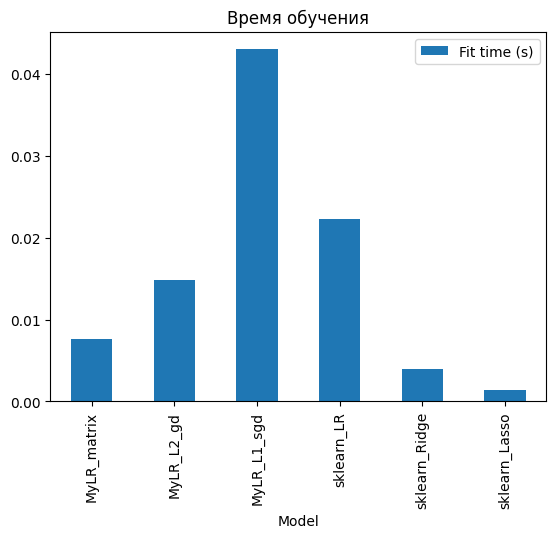

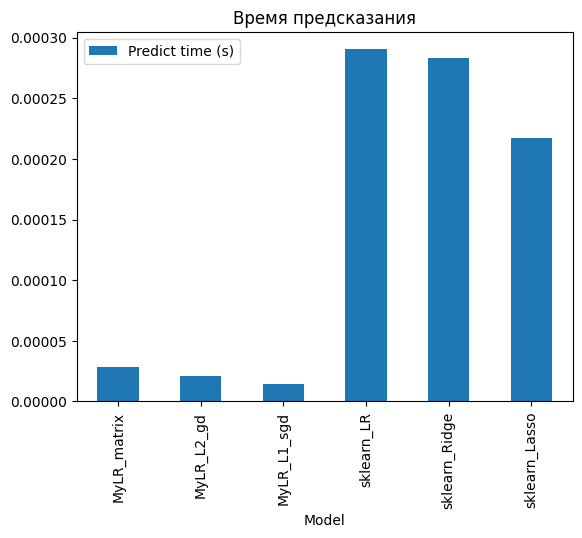

In [5]:
results_df.plot(x="Model", y="R2", kind="bar", title="Качество моделей (R2)")
plt.show()

results_df.plot(x="Model", y="Fit time (s)", kind="bar", title="Время обучения")
plt.show()

results_df.plot(x="Model", y="Predict time (s)", kind="bar", title="Время предсказания")
plt.show()


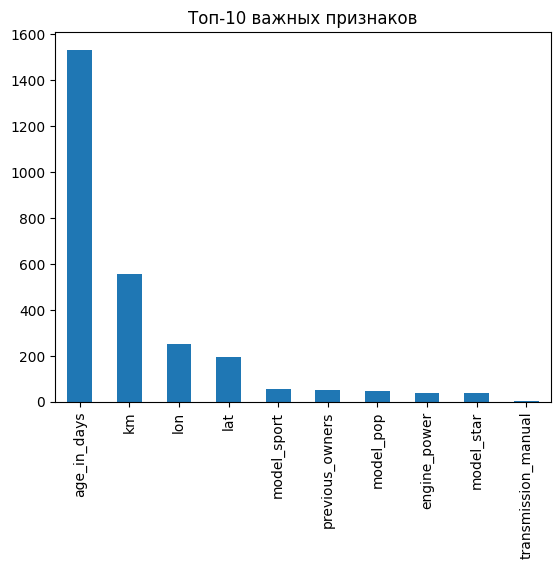

In [6]:
coefs = trained_models["MyLR_matrix"].coefs_.ravel()
importance = pd.Series(np.abs(coefs), index=feature_names)
importance = importance.sort_values(ascending=False)

importance.head(10).plot(kind="bar", title="Топ-10 важных признаков")
plt.show()


## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)